In [1]:
! pip show numpy
! pip show scipy

Name: numpy
Version: 1.15.1
Summary: NumPy: array processing for numbers, strings, records, and objects.
Home-page: http://www.numpy.org
Author: Travis E. Oliphant et al.
Author-email: None
License: BSD
Location: /Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages
Requires: 
Required-by: xgboost, tf-nightly-2.0-preview, tensorflowjs, tensorflow, tensorflow-hub, tensorboard, tb-nightly, statsmodels, scipy, patsy, pandas, opt-einsum, moviepy, matplotlib, Keras, Keras-Preprocessing, Keras-Applications, imageio, h5py, gensim
Name: scipy
Version: 1.3.1
Summary: SciPy: Scientific Library for Python
Home-page: https://www.scipy.org
Author: None
Author-email: None
License: BSD
Location: /Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages
Requires: numpy
Required-by: xgboost, statsmodels, Keras, gensim


In [2]:
import numpy as np
import scipy
from scipy import optimize

def load_csv_to_ndarray(filepath):
    # Read using numpy lib and return all rows, no header in this case
    return np.genfromtxt(filepath, dtype=float, delimiter=',')

def transform_feature(one_dim_feature_vector, weighted=False):
    transformed_feature_vector = np.zeros((len(one_dim_feature_vector), 2*128))

    for i in range(0, len(one_dim_feature_vector)):
        feature = one_dim_feature_vector[i]
        transformed_feature = np.zeros(2*128)

        for j in range(0, 128):
            transformed_feature[2*j] = np.cos((j+1) * feature)
            if weighted:
                transformed_feature[2*j] = transformed_feature[2*j] * np.ceil(((2*j)+1)/2)

            transformed_feature[(2*j)+1] = np.sin((j+1) * feature)
            if weighted:
                transformed_feature[(2*j)+1] = transformed_feature[(2*j)+1] * np.ceil(((2*j)+2)/2)

        transformed_feature_vector[i] = transformed_feature

    return transformed_feature_vector

# Use np.linalg.lstsq to compute the minimum Euclidean norm solution
def compute_min_euclidean_norm_solution(feature_matrix, label_vector, use_pinv=True):
    if use_pinv:
        pseudo_inverse = np.linalg.pinv(feature_matrix)
        print('USE PINV')
        return np.dot(pseudo_inverse, label_vector)

    print('USE LSTSQ')
    # Get X'
    feature_matrix_transposed = feature_matrix.T

    # Compute X'X (covariance matrix)
    feature_matrix_matmul = np.dot(feature_matrix_transposed, feature_matrix)

    # Basically, lstsq(M_1, M_2) will return a solution, let say M_sol
    # M_sol has the least squares or l2 norms amongst other solutions (there can also be no solution)
    # M_sol fulfills the equation: np.dot(M_1, M_sol) = M_2
    # In our case, M_1 would be X'X, M_2 would be X'y and M_sol would be the weights we seek
    return np.linalg.lstsq(feature_matrix_matmul, np.dot(feature_matrix_transposed, label_vector), rcond=None)[0]

def create_weights_diagonal_matrix(squared=False):
    weights = np.zeros(2*128)

    for j in range(0, 2*128):
        weights[j] = np.ceil((j+1)/2)
        if squared:
            weights[j] = weights[j] ** 2

    return weights, np.diag(weights)

def count_nonzero_entries(weights, threshold=1.e-15):
    count = 0

    for weight in weights:
        if abs(weight) <= threshold:
            count = count + 1

    return count

def calculate_squared_loss(prediction_values, label_vector, mean=True):
    # Calculate sigma (y_hat - y)^2
    total_squared_loss = np.sum((prediction_values - label_vector) ** 2)

    # Divide error by total observations to get mean squared loss
    if mean:
        return total_squared_loss / len(label_vector)

    return total_squared_loss

def compute_w_euclid(use_pinv=True):
    print('Experiment 1a: ')
    print()

    train_df = load_csv_to_ndarray('hw3p1_train.csv')
    test_df = load_csv_to_ndarray('hw3p1_test.csv')

    one_dim_feature_vector = train_df[:,0]
    label_vector = train_df[:,1]

    feature_matrix = transform_feature(one_dim_feature_vector)

    sol = compute_min_euclidean_norm_solution(feature_matrix, label_vector, use_pinv)
    print(sol[0:16])
    print(sol[240:256])
    
    print('Norm:')
    print(np.linalg.norm(sol))

    test_feature_matrix = transform_feature(test_df)
    test_pred_result = np.dot(test_feature_matrix, sol)

    print('Mean squared loss: ')
    print(calculate_squared_loss(np.dot(feature_matrix, sol), label_vector))
    print()

    print('Number of nonzero entries:')
    print(count_nonzero_entries(sol))
    print()

    print('--------------------------------')

    # By default, Mac OS X can't directly render matplotlib
    # To use matplotlib, please use Jupyter Notebook or set the backend properly (https://stackoverflow.com/questions/21784641/installation-issue-with-matplotlib-python)
    import matplotlib.pyplot as plt
    
    fig = plt.figure(figsize=(10, 10))
    
    plt.title('Minimum Euclidean Plot')
    plt.plot(test_df, test_pred_result, color='pink', linewidth=1, marker='o', markersize=3, mfc='white', mec='black')
    
    plt.savefig('1a.png', bbox_inches='tight')
    
    plt.show()

def compute_w_weighted(use_pinv=True):
    print('Experiment 1b: ')
    print()

    train_df = load_csv_to_ndarray('hw3p1_train.csv')
    test_df = load_csv_to_ndarray('hw3p1_test.csv')

    one_dim_feature_vector = train_df[:,0]
    label_vector = train_df[:,1]

    feature_matrix = transform_feature(one_dim_feature_vector)

    _, weights_diagonal_matrix = create_weights_diagonal_matrix()

    # Stack feature_matrix with weights_diagonal
    weighted_feature_matrix = np.vstack((feature_matrix, weights_diagonal_matrix))

    # Pad label_vector with zeros
    padded_label_vector = np.zeros(2*128 + len(label_vector))
    padded_label_vector[0:len(label_vector)] = label_vector

    sol = compute_min_euclidean_norm_solution(weighted_feature_matrix, padded_label_vector, use_pinv)
    print(sol[0:16])
    print(sol[240:256])
    
    print('Norm:')
    print(np.linalg.norm(sol))

    test_feature_matrix = transform_feature(test_df)
    test_pred_result = np.dot(test_feature_matrix, sol)

    print('Mean squared loss: ')
    print(calculate_squared_loss(np.dot(feature_matrix, sol), label_vector))
    print()

    print('Number of nonzero entries:')
    print(count_nonzero_entries(sol))
    print()

    print('--------------------------------')

    # By default, Mac OS X can't directly render matplotlib
    # To use matplotlib, please use Jupyter Notebook or set the backend properly (https://stackoverflow.com/questions/21784641/installation-issue-with-matplotlib-python)
    import matplotlib.pyplot as plt
    
    fig = plt.figure(figsize=(10, 10))
    
    plt.title('Minimum Weighted Euclidean Plot')
    plt.plot(test_df, test_pred_result, color='pink', linewidth=1, marker='o', markersize=3, mfc='white', mec='black')
    
    plt.savefig('1b.png', bbox_inches='tight')
    
    plt.show()
    
def compute_w_weighted_1(use_pinv=True):
    print('Experiment 1b: ')
    print()

    train_df = load_csv_to_ndarray('hw3p1_train.csv')
    test_df = load_csv_to_ndarray('hw3p1_test.csv')

    one_dim_feature_vector = train_df[:,0]
    label_vector = train_df[:,1]

    feature_matrix = transform_feature(one_dim_feature_vector)
    weighted_feature_matrix = transform_feature(one_dim_feature_vector, True)

    sol = compute_min_euclidean_norm_solution(weighted_feature_matrix, label_vector, use_pinv)
    print(sol[0:16])
    print(sol[240:256])
    
    print('Norm:')
    print(np.linalg.norm(sol))

    test_feature_matrix = transform_feature(test_df)
    test_pred_result = np.dot(test_feature_matrix, sol)

    print('Mean squared loss: ')
    print(calculate_squared_loss(np.dot(feature_matrix, sol), label_vector))
    print()

    print('Number of nonzero entries:')
    print(count_nonzero_entries(sol))
    print()

    print('--------------------------------')

    # By default, Mac OS X can't directly render matplotlib
    # To use matplotlib, please use Jupyter Notebook or set the backend properly (https://stackoverflow.com/questions/21784641/installation-issue-with-matplotlib-python)
    import matplotlib.pyplot as plt
    
    fig = plt.figure(figsize=(10, 10))
    
    plt.title('Minimum Weighted Euclidean Plot')
    plt.plot(test_df, test_pred_result, color='pink', linewidth=1, marker='o', markersize=3, mfc='white', mec='black')
    
    plt.savefig('1b_1.png', bbox_inches='tight')
    
    plt.show()

def compute_w_dantzig():
    print('Experiment 1c: ')
    print()

    train_df = load_csv_to_ndarray('hw3p1_train.csv')
    test_df = load_csv_to_ndarray('hw3p1_test.csv')

    one_dim_feature_vector = train_df[:,0]
    label_vector = train_df[:,1]

    feature_matrix = transform_feature(one_dim_feature_vector)

    # 256
    weights, _ = create_weights_diagonal_matrix()

    # 512
    appended_weights = np.zeros(2*2*128)

    # First 256 is for w, last 256 for v
    # Give zero weights to w
    # We care about sum(abs(w)), i.e. sum(v)
    appended_weights[2*128:2*2*128] = weights

    # Equality constraint

    # A^tA
    A_eq = np.dot(feature_matrix.transpose(), feature_matrix)
    # Add 256 more zero columns to fit for v
    A_eq = np.hstack((A_eq, np.zeros((2*128, 2*128))))
    print(A_eq.shape)
    # Label vector stay as is, A^tb will have shape 256
    b_eq = np.dot(feature_matrix.transpose(), label_vector)
    print(b_eq.shape)

    # Inequality constraint

    # Each pair of v and w needs to follow: - w - v <= 0 and w - v <= 0
    A_ub = np.zeros((512, 512))
    for i in range(0, int(len(A_ub)/2)):
        # -w_j - v_j
        A_ub[2*i][i] = -1
        A_ub[2*i][i+256] = -1

        # w_j - v_j
        A_ub[(2*i)+1][i] = 1
        A_ub[(2*i)+1][i+256] = -1

    # Upper bound <= 0
    b_ub = np.zeros(512)

    # No need to set bound for v, because the default is nonnegative
    # Set bound for w from -inf to inf (None, None)
    # Set bound for v from 0 to inf (0, None)
    bounds = []
    for i in range(0, 256):
        bounds.append((None, None))
    for i in range(0, 256):
        bounds.append((0, None))

    res = scipy.optimize.linprog(appended_weights, A_eq=A_eq, b_eq=b_eq, A_ub=A_ub, b_ub=b_ub, bounds=bounds, method='revised simplex')

    dantzig_sol = res.x[0:256]

    print('Mean squared loss: ')
    print(calculate_squared_loss(np.dot(feature_matrix, dantzig_sol), label_vector))
    print()

    print('Number of nonzero entries:')
    print(count_nonzero_entries(dantzig_sol))
    print()

    print('--------------------------------')

    # By default, Mac OS X can't directly render matplotlib
    # To use matplotlib, please use Jupyter Notebook or set the backend properly (https://stackoverflow.com/questions/21784641/installation-issue-with-matplotlib-python)
    import matplotlib.pyplot as plt
    
    test_feature_matrix = transform_feature(test_df)
    test_pred_result = np.dot(test_feature_matrix, dantzig_sol)
    
    fig = plt.figure(figsize=(10, 10))
    
    plt.title('Dantzig Selector Euclidean Plot')
    plt.plot(test_df, test_pred_result, color='pink', linewidth=1, marker='o', markersize=3, mfc='white', mec='black')
    
    plt.savefig('1c.png', bbox_inches='tight')
    
    plt.show()

In [3]:
create_weights_diagonal_matrix()[1]

array([[  1.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   1.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   2., ...,   0.,   0.,   0.],
       ...,
       [  0.,   0.,   0., ..., 127.,   0.,   0.],
       [  0.,   0.,   0., ...,   0., 128.,   0.],
       [  0.,   0.,   0., ...,   0.,   0., 128.]])

In [4]:
compute_w_weighted_1()

Experiment 1b: 

USE PINV
[ 7.30454419e-06 -1.09844990e-06 -1.01910365e-05 -8.10530751e-06
 -2.07158392e-05  1.41230318e-05  9.17684985e-06  5.29343861e-05
 -1.59172279e-05  1.28320707e-06 -5.38155047e-05 -3.54845512e-05
 -5.36232108e-05  4.03969022e-06  7.09107542e-05  4.20326193e-05]
[-3.49589402e-04 -2.38908654e-05  1.03906855e-04 -1.67532147e-03
 -9.39202295e-04 -4.04620679e-04 -5.17341581e-04  5.31007220e-04
  9.19475953e-04  6.24402564e-05  1.99933386e-05 -2.87462728e-05
  9.10657080e-04 -2.15100932e-04 -7.66034405e-04 -4.69621046e-04]
Norm:
0.008253307027547398
Mean squared loss: 
1.430257565428489

Number of nonzero entries:
0

--------------------------------


<Figure size 1000x1000 with 1 Axes>

Experiment 1a: 

USE PINV
[ 0.04908832 -0.00718577 -0.03461254 -0.02689775 -0.03677315  0.02500117
  0.01177851  0.07089182 -0.01637569  0.00126613 -0.0481524  -0.0313346
 -0.03984917  0.00309323  0.04602581  0.02754584]
[-0.01502363 -0.00092013  0.00433708 -0.073644   -0.04114842 -0.01717534
 -0.02861273  0.0287844   0.04939452  0.00283636  0.00035091 -0.00115395
  0.04815244 -0.01150922 -0.04030375 -0.0240235 ]
Norm:
0.605642094963311
Mean squared loss: 
4.3685989299157195e-30

Number of nonzero entries:
0

--------------------------------


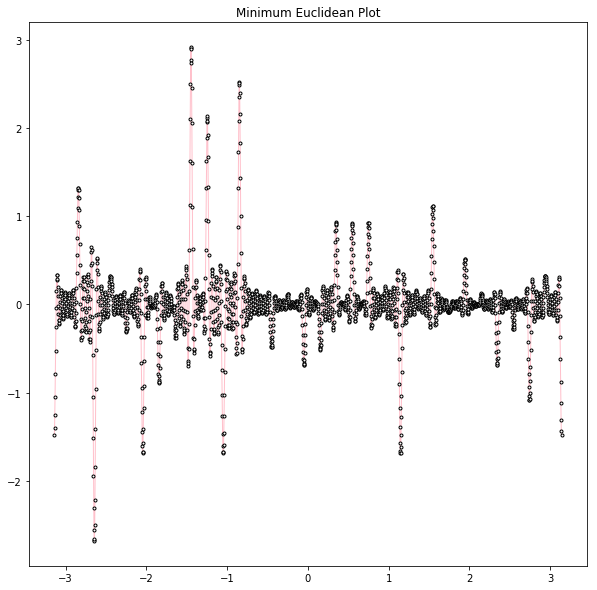

In [5]:
compute_w_euclid()
# 0.605642094963311
# Mean squared loss: 
# 4.3685989299157195e-30

Experiment 1b: 

USE PINV
[ 0.4032034  -0.06122629 -0.23717626 -0.19003089 -0.19338498  0.12254494
  0.05226381  0.27718176 -0.05410099  0.00179812 -0.10968115 -0.07202143
 -0.07760895  0.0042153   0.0720863   0.04318911]
[-8.04757022e-05  1.50789327e-06  2.09760474e-05 -3.10685887e-04
 -1.22647149e-04 -4.49403833e-05 -5.42573418e-05  4.60438734e-05
  2.82446691e-05  8.82269746e-06  1.32173310e-05 -8.67592810e-06
  2.37082353e-05  1.22843870e-06 -6.58580580e-05 -4.84817254e-05]
Norm:
0.6671217859249595
Mean squared loss: 
0.7593931354886225

Number of nonzero entries:
0

--------------------------------


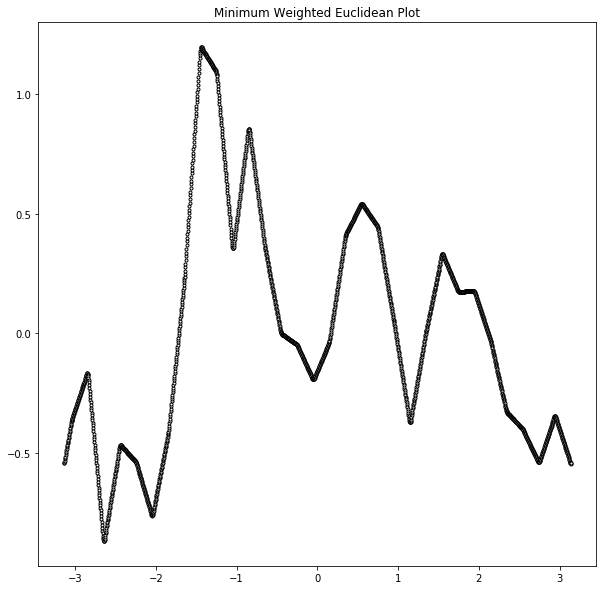

In [6]:
compute_w_weighted()
# Norm:
# 0.6671217859249595
# Mean squared loss: 
# 0.7593931354886225

Experiment 1c: 

(256, 512)
(256,)


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/optimize/_linprog_util.py:763: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  warn(redundancy_warning, OptimizeWarning)


Mean squared loss: 
1.9066399504348748e-28

Number of nonzero entries:
222

--------------------------------


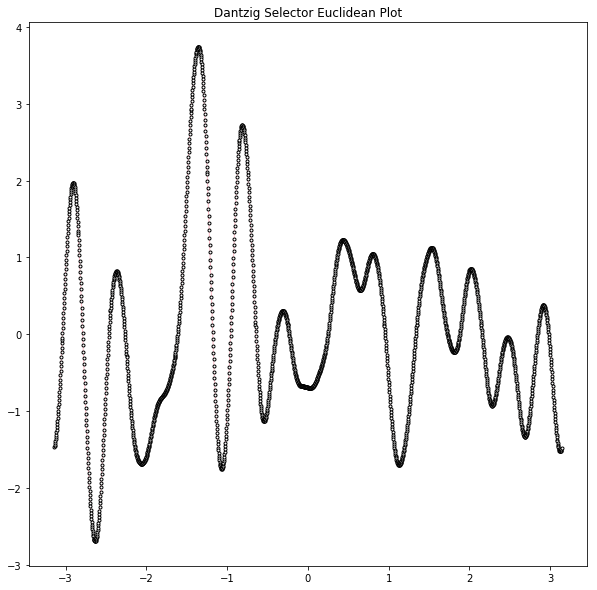

In [7]:
compute_w_dantzig()

In [8]:
import numpy as np

train_df = load_csv_to_ndarray('hw3p1_train.csv')
test_df = load_csv_to_ndarray('hw3p1_test.csv')

one_dim_feature_vector = train_df[:,0]
label_vector = train_df[:,1]

feature_matrix = transform_feature(one_dim_feature_vector)
    
np.linalg.matrix_rank(feature_matrix)

32

In [9]:
simple_sol = np.dot(np.linalg.inv(np.dot(feature_matrix.transpose(), feature_matrix) + np.identity(256)), np.dot(feature_matrix.transpose(), label_vector))

In [10]:
simple_sol

array([ 0.04874669, -0.00713521, -0.03437277, -0.02670942, -0.03648349,
        0.0248028 ,  0.01168478,  0.07033452, -0.01624532,  0.00125532,
       -0.04777477, -0.0310872 , -0.03953353,  0.00306846,  0.04566131,
        0.02732904,  0.05709415, -0.03455439, -0.03635564, -0.00889714,
       -0.02993519, -0.04863674, -0.09080084, -0.01014127,  0.05261621,
        0.06074676, -0.0148533 , -0.01249749,  0.05072616,  0.02555808,
       -0.00890368, -0.04475589,  0.00356787, -0.00091837, -0.02781868,
       -0.03238666, -0.04150209,  0.01698669,  0.05098057,  0.08165111,
        0.02433845,  0.0175831 ,  0.02083749,  0.00870099,  0.01196351,
       -0.08577028, -0.03771627,  0.01270662,  0.03315041,  0.04604823,
        0.01466846,  0.03724452, -0.03123395, -0.00386438, -0.07356475,
        0.00489505,  0.02603896,  0.05885882,  0.00722802, -0.02382262,
        0.011518  , -0.02254156, -0.01273487, -0.02304905, -0.00873881,
       -0.02169924, -0.02222056,  0.05989986,  0.07447583,  0.00

In [11]:
np.dot(feature_matrix, simple_sol) - label_vector

array([ 0.00012387, -0.01104883,  0.02047247, -0.00305136,  0.00183661,
        0.0130771 ,  0.00699649,  0.00247518, -0.02256048, -0.01615112,
        0.01382025, -0.01928311, -0.00045617,  0.00415699, -0.00069533,
        0.00548697,  0.0038207 , -0.00725495, -0.00726007, -0.00722443,
       -0.0008603 ,  0.01338651, -0.00072527, -0.00857496,  0.00086095,
       -0.00393021, -0.00089551,  0.00525088,  0.00192606,  0.008057  ,
       -0.00310716,  0.01097686])

In [12]:
count_nonzero_entries(simple_sol)

0

In [13]:
transform_feature(np.hstack((train_df[:,0], [1]))).shape
# np.hstack((train_df[:,0], [1]))

(33, 256)

In [14]:
128 ** 2

16384

In [15]:
np.linalg.norm(np.array([1,2,3,4,5]))

7.416198487095663

In [16]:
np.sqrt(np.sum(np.array([1+4+9+16+25])))

7.416198487095663

In [17]:
np.dot(np.diag([1,2,3]), np.diag([1,2,3]))

array([[1, 0, 0],
       [0, 4, 0],
       [0, 0, 9]])